<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/musical_instruments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!ls /content/drive/MyDrive/

'Classical Machine Learning'  'Kaggle Dataset Colab.gdoc'   PyTorch
'Colab Notebooks'	       langchain		    Tensorflow
 EDA			       LangGraph		    Trading
 fastapi		      'Machine Learninig'	    Untitled0.ipynb
 GenerativeAI		       music_instruments	    Valeo


In [19]:
!mkdir -p ~/.config/kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.config/kaggle/kaggle.json
!chmod 600 ~/.config/kaggle/kaggle.json

In [20]:
!pip install kaggle

In [21]:
!kaggle datasets download -d nikolasgegenava/music-instruments

Dataset URL: https://www.kaggle.com/datasets/nikolasgegenava/music-instruments
License(s): MIT
  0% 0.00/6.21M [00:00<?, ?B/s]
100% 6.21M/6.21M [00:00<00:00, 1.05GB/s]


In [23]:
# Change the unzip command to specify the output directory
!unzip music-instruments.zip -d /content/drive/MyDrive/music_instruments

Archive:  music-instruments.zip
replace /content/drive/MyDrive/music_instruments/music_instruments/accordion/0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0001.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0002.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0003.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0004.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0005.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0006.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0007.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0008.jpg  
  inflating: /content/drive/MyDrive/music_instruments/music_instruments/accordion/0009.jpg  
  in

In [121]:
import os
for dir, subdir, files in os.walk('/content/drive/MyDrive/music_instruments'):
  if len(subdir) > 1:
    dirs = [os.path.abspath(dir) for dir in subdir]
print(dirs)

['/content/accordion', '/content/banjo', '/content/drum', '/content/flute', '/content/guitar', '/content/harmonica', '/content/saxophone', '/content/sitar', '/content/tabla', '/content/violin']


In [152]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [153]:
data_dir = '/content/drive/MyDrive/music_instruments/music_instruments/'

In [154]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 128

In [155]:
# Create a dataset from images in directories
# Assuming your data is organized in subdirectories where each subdirectory is a class
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=128
)

Found 1806 files belonging to 10 classes.
Using 1445 files for training.


In [156]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=128
)

Found 1806 files belonging to 10 classes.
Using 361 files for validation.


In [157]:
class_names = val_ds.class_names

In [158]:
def preprocess(image,label):
  image = tf.cast(image,tf.float32)
  image = image/255.0
  return tf.cast(image,tf.float32),label

In [159]:
train_ds = train_ds.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [160]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [161]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [162]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [163]:
vgg_model.trainable = True
for layer in vgg_model.layers[:-4]:
  layer.trainable = False

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

In [165]:
model = Sequential([
    vgg_model,
    GlobalAveragePooling2D(),
    Dense(10, activation='softmax')
])


In [166]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 7,084,554 (27.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [167]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss',patience=5,verbose=True)

In [168]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [169]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[earlystopping])

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 994ms/step - accuracy: 0.1404 - loss: 2.5143 - val_accuracy: 0.1136 - val_loss: 2.3713
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 719ms/step - accuracy: 0.1574 - loss: 2.2969 - val_accuracy: 0.1690 - val_loss: 2.1692
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 697ms/step - accuracy: 0.1752 - loss: 2.1410 - val_accuracy: 0.1662 - val_loss: 2.1430
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 698ms/step - accuracy: 0.2095 - loss: 2.0590 - val_accuracy: 0.2853 - val_loss: 2.0260
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - accuracy: 0.3024 - loss: 1.9229 - val_accuracy: 0.2632 - val_loss: 1.9997
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 682ms/step - accuracy: 0.2950 - loss: 1.8588 - val_accuracy: 0.2881 - val_loss: 1.9559
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 710ms/step - accuracy: 0.3459 - loss: 1.6877 - val_accuracy: 0.4598 - val_loss: 1.6479
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 675ms/step - accuracy: 0.4680 - loss: 1.5093 - val_accurac

In [170]:
loss,acc = model.evaluate(val_ds)
print(f"loss = {loss}")
print(f"accuracy = {acc}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - accuracy: 0.7205 - loss: 0.9858
loss = 1.025864601135254
accuracy = 0.7091412544250488


In [171]:
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


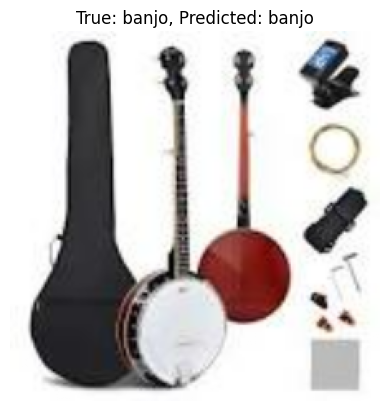

In [178]:
# prompt: randomly check any image from dataset and predict

import matplotlib.pyplot as plt
import numpy as np

# Get a random batch from the validation dataset
for images, labels in val_ds.take(1):
  # Get a random index within the batch
  random_index = np.random.randint(0, len(images))
  random_image = images[random_index]
  random_label = labels[random_index]

  # Predict the class of the random image
  predictions = model.predict(tf.expand_dims(random_image, 0))
  predicted_class = class_names[np.argmax(predictions)]
  true_class = class_names[random_label.numpy()]

  # Display the image and prediction
  plt.imshow(random_image.numpy())
  plt.title(f"True: {true_class}, Predicted: {predicted_class}")
  plt.axis("off")
  plt.show()

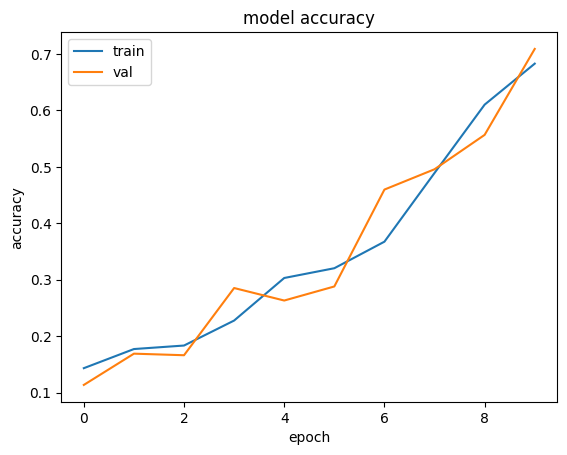

In [179]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

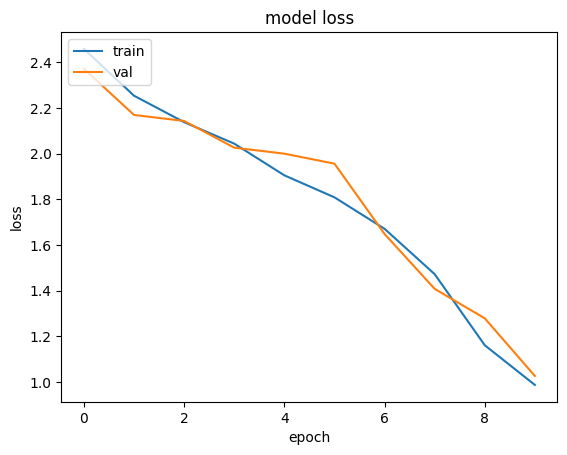

In [180]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')